In [1]:
import json
import os
import random
import time
import math

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.cuda import amp
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
torch.manual_seed(1)
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print(device)

cuda:7


In [2]:
os.chdir('/mnt/tapioca/Workspace/hw')

In [3]:
!ls

LSTM_hw.ipynb  dataset


In [4]:
# './dataset/A3_data/train.json'
letter_list = ['abcdefghijklmnopqrstuvwxyz']

In [5]:
class myDataLoader(Dataset):
    def __init__(self, data_path):
        super(myDataLoader, self).__init__()
        self.datas_list = []
        self.labels_list = []
        self.EOS_token = 1

        self.letter_list = ['abcdefghijklmnopqrstuvwxyz']
        with open(data_path, 'r') as f:
            train_data = json.load(f)

            for ele in train_data:
                while ele['input']:
                    input = ele['input'].pop()
                    input_int = self.word2int(input)
                    label_int = self.word2int(ele['target'])
                    self.datas_list.append(input_int)
                    self.labels_list.append(label_int)

    def word2int(self, word:str):
        int_list = []
        for letter in word:
            letter_idx = self.letter_list[0].find(letter)+2
            int_list.append(letter_idx)
        int_list.append(self.EOS_token)
        return int_list

    def __getitem__(self, idex):
        return torch.LongTensor(self.datas_list[idex]).to(device), torch.LongTensor(self.labels_list[idex]).to(device)
    def __len__(self):
        return len(self.datas_list)

In [6]:
#Encoder
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layer_num=5):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.layer_num)

    def forward(self, input, hidden):
        input = input.view(-1, 1)
        embedded = self.embedding(input)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        h_0 = torch.zeros(self.layer_num, 1, self.hidden_size, device=device)
        c_0 = torch.zeros(self.layer_num, 1, self.hidden_size, device=device)
        return (h_0, c_0)

#Decoder
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, layer_num = 5):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.layer_num)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output[0])
        #output = F.softmax(output, dim=1)
        return output, hidden

In [26]:
#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
def myOneHot(idx):
    onthot = torch.zeros(1, vocab_size, device=device)
    onthot[0][idx] = 1
    return onthot
def int2word(vec:list):
    word = ''
    for ele in vec:
        letter = letter_list[0][int(ele)-2]
        word += letter
    return word
def print_result(encoder, decoder , detail = False):
    test_data = './dataset/A3_data/test.json'
    new_test_data = './dataset/A3_data/new_test.json'

    for dataset in [test_data, new_test_data]:
        input_list = []
        predict_list, target_list, bleu_list = test(encoder, decoder, dataset)
        test_set = myDataLoader(dataset)
        for test_pair in test_set:
            input_tensor = test_pair[0]
            input_list.append(int2word(input_tensor[:-1]))

        for predict, GT, input in zip(predict_list, target_list, input_list):
            if detail:
                print(f'input:  {input}')
                print(f'target: {GT}')
                print(f'pred:   {predict}')
                print('==================================================')
    print('========================================================')
def show(loss_list, result1, result2):
    plt.tight_layout()
    plt.rcParams['xtick.color'] = 'red'
    plt.rcParams['ytick.color'] = 'red'
    plt.plot(result1)
    plt.show()
    plt.plot(result2)
    plt.show()
    plt.plot(loss_list)
    plt.show()

In [8]:
SOS_token = 0
EOS_token = 1

#The number of vocabulary
vocab_size = 29
teacher_forcing_ratio = 0.4
LR = 0.05


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, Gscaler, max_length=20):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    #----------sequence to sequence part for encoder----------#
    with amp.autocast():
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)


        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False


        #----------sequence to sequence part for decoder----------#
        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)

                label = myOneHot(target_tensor[di]) # oneHot!!
                loss += criterion(decoder_output, label)
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                label = myOneHot(target_tensor[di])
                loss += criterion(decoder_output, label)
                if decoder_input.item() == EOS_token:
                    break
    Gscaler.scale(loss).backward()
    Gscaler.step(encoder_optimizer)
    Gscaler.step(decoder_optimizer)
    Gscaler.update()

    return loss.item() / target_length


def trainIters(encoder, decoder, n_iters, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    dataset = myDataLoader('./dataset/A3_data/train.json')
    Gscaler = amp.GradScaler()

    plot_losses = []
    test1_score = []
    test2_score = []
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # your own dataloader
    training_pairs = dataset

    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        print(f'epoch : {epoch}')
        start = time.time()
        plot_loss_total = 0
        for iter in range(1, n_iters + 1):
            training_pair = training_pairs[iter - 1]

            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion, Gscaler)

            print_loss_total += loss
            plot_loss_total += loss


            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0

                print('\r%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg),end='')


        plot_losses.append(plot_loss_total/n_iters)
        _, _, final_score = test(encoder, decoder, './dataset/A3_data/test.json')
        test1_score.append(final_score)
        _, _, final_score = test(encoder, decoder, './dataset/A3_data/new_test.json')
        test2_score.append(final_score)
        print('--------------------------------------------------')

    return plot_losses, test1_score, test2_score


def test(encoder, decoder, dataset:str, max_length=20):
    Testset = myDataLoader(dataset)
    start = time.time()
    score = 0
    predict_list = []
    target_list = []

    correct = 0
    for iter in range(1, len(Testset) + 1):
        Test_pair = Testset[iter - 1]

        input_tensor = Test_pair[0]
        Test_target = Test_pair[1]
        encoder_hidden = encoder.initHidden()

        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)


        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        predict = []
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            predict.append(topi)
            if decoder_input.item() == EOS_token:
                break

        predict = int2word(predict[:-1])
        Test_target = int2word(Test_target[:-1])
        predict_list.append(predict)
        target_list.append(Test_target)
        if predict == Test_target:
            correct += 1
        score += compute_bleu(predict, Test_target)

    final_score = score/len(Testset)
    word_acc = correct/len(Testset)
    print(f"\n{dataset.split('/')[-1].split('.')[0]}:")
    print(f'\tscore : {final_score}')
    print(f'\tacc : {word_acc}')
    return predict_list, target_list, final_score


# Teacher forcing:0.4, hidden_size=512, layer=5, lr=0.05,epochs:70

In [ ]:
hidden_size = 512
encoder1 = EncoderLSTM(vocab_size, hidden_size, 5).to(device)
decoder1 = DecoderLSTM(hidden_size, vocab_size, 5).to(device)
loss_list, result1, result2 = trainIters(encoder1, decoder1, 12925, print_every=100,epochs=70)

epoch : 0
7m 27s (- 0m 0s) (12900 99%) 2.07435
test:
	score : 0.04150170969116289
	acc : 0.0

new_test:
	score : 0.057658492262600156
	acc : 0.0
--------------------------------------------------
epoch : 1
8m 22s (- 0m 0s) (12900 99%) 1.77492
test:
	score : 0.05922934266761432
	acc : 0.0

new_test:
	score : 0.05960723335258375
	acc : 0.0
--------------------------------------------------
epoch : 2
8m 17s (- 0m 0s) (12900 99%) 1.53876
test:
	score : 0.06687920041970112
	acc : 0.0

new_test:
	score : 0.0597411092709492
	acc : 0.0
--------------------------------------------------
epoch : 3
7m 55s (- 0m 0s) (12900 99%) 1.24398
test:
	score : 0.09524799806557863
	acc : 0.0

new_test:
	score : 0.08593326070476043
	acc : 0.0
--------------------------------------------------
epoch : 4
8m 6s (- 0m 0s) (12900 99%) 0.964055
test:
	score : 0.13309488847499618
	acc : 0.0

new_test:
	score : 0.13188078440370704
	acc : 0.02
--------------------------------------------------
epoch : 5
8m 24s (- 0m 0


test:
	score : 0.9133140848677744
	acc : 0.86
input:  contenpted
target: contented
pred:   contepted
input:  begining
target: beginning
pred:   beginning
input:  problam
target: problem
pred:   problems
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juice
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   arranged
input:  poartry
target: poetry
pred:   portry
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input:

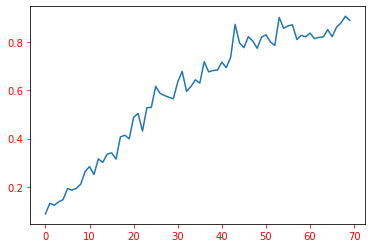

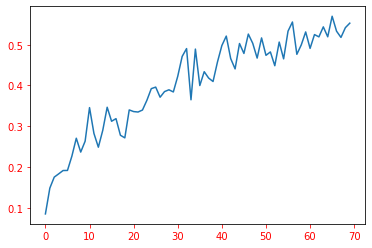

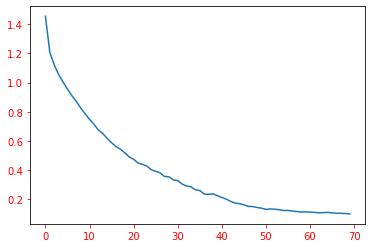

In [29]:
print_result(encoder1, decoder1, True)
show(loss_list, result1, result2)

# Teacher forcing:0.4, hidden_size=256, layer=2, lr=0.05,epochs:70

In [11]:
hidden_size = 256
encoder2 = EncoderLSTM(vocab_size, hidden_size, 2).to(device)
decoder2 = DecoderLSTM(hidden_size, vocab_size, 2).to(device)

In [12]:
loss_list, result1, result2 = trainIters(encoder2, decoder2, 12925, print_every=100,epochs=70)

epoch : 0
6m 0s (- 0m 0s) (12900 99%) 1.208505
test:
	score : 0.1295061743293694
	acc : 0.0

new_test:
	score : 0.08730057286192114
	acc : 0.0
--------------------------------------------------
epoch : 1
5m 32s (- 0m 0s) (12900 99%) 1.04027
test:
	score : 0.1435070589007645
	acc : 0.0

new_test:
	score : 0.12820633078168764
	acc : 0.02
--------------------------------------------------
epoch : 2
5m 13s (- 0m 0s) (12900 99%) 0.80124
test:
	score : 0.17977760002486565
	acc : 0.0

new_test:
	score : 0.17734537606823586
	acc : 0.04
--------------------------------------------------
epoch : 3
6m 26s (- 0m 0s) (12900 99%) 0.78521
test:
	score : 0.20774849017290462
	acc : 0.0

new_test:
	score : 0.2020968720424608
	acc : 0.04
--------------------------------------------------
epoch : 4
6m 11s (- 0m 0s) (12900 99%) 0.74341
test:
	score : 0.22468923228683313
	acc : 0.0

new_test:
	score : 0.21280354418477304
	acc : 0.04
--------------------------------------------------
epoch : 5
3m 37s (- 0m 0


test:
	score : 0.8679614201481775
	acc : 0.82
input:  contenpted
target: contented
pred:   contentided
input:  begining
target: beginning
pred:   beginning
input:  problam
target: problem
pred:   problem
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juci
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   arranged
input:  poartry
target: poetry
pred:   portary
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input

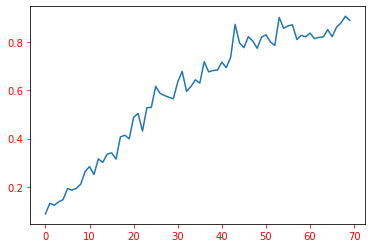

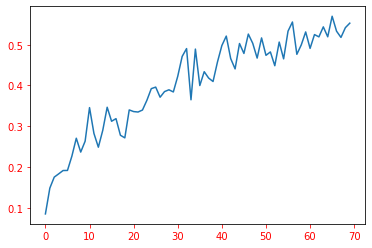

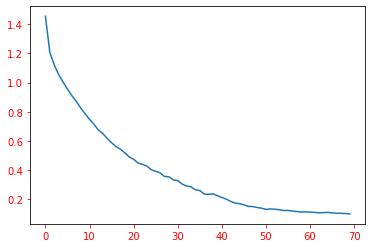

In [28]:
print_result(encoder2, decoder2, True)
show(loss_list, result1, result2)

# Teacher forcing:0.4, hidden_size=256, layer=1, lr=0.05,epochs:70

In [16]:
hidden_size = 256
encoder3 = EncoderLSTM(vocab_size, hidden_size, 1).to(device)
decoder3 = DecoderLSTM(hidden_size, vocab_size, 1).to(device)

In [17]:
loss_list, result1, result2 = trainIters(encoder3, decoder3, 12925, print_every=100,epochs=70)

epoch : 0
5m 7s (- 0m 0s) (12900 99%) 1.236611
test:
	score : 0.08709462604013306
	acc : 0.0

new_test:
	score : 0.08468026966399726
	acc : 0.0
--------------------------------------------------
epoch : 1
2m 48s (- 0m 0s) (12900 99%) 1.14412
test:
	score : 0.13110495430959673
	acc : 0.0

new_test:
	score : 0.14798994827440412
	acc : 0.04
--------------------------------------------------
epoch : 2
3m 16s (- 0m 0s) (12900 99%) 1.00162
test:
	score : 0.12301700659330737
	acc : 0.0

new_test:
	score : 0.1749827714666285
	acc : 0.04
--------------------------------------------------
epoch : 3
4m 24s (- 0m 0s) (12900 99%) 0.96132
test:
	score : 0.1371836488919481
	acc : 0.0

new_test:
	score : 0.18295757948062166
	acc : 0.04
--------------------------------------------------
epoch : 4
5m 32s (- 0m 0s) (12900 99%) 0.97295
test:
	score : 0.1464051850027371
	acc : 0.0

new_test:
	score : 0.19115006676261706
	acc : 0.04
--------------------------------------------------
epoch : 5
4m 45s (- 0m 0


test:
	score : 0.891628170701854
	acc : 0.84
input:  contenpted
target: contented
pred:   contented
input:  begining
target: beginning
pred:   begiing
input:  problam
target: problem
pred:   problem
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juice
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   raranged
input:  poartry
target: poetry
pred:   partury
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input:  s

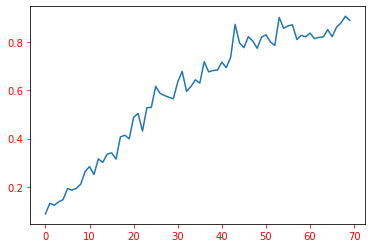

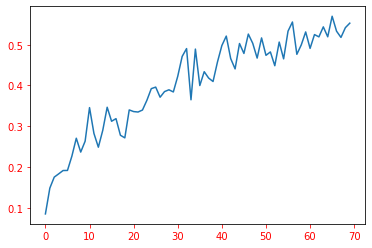

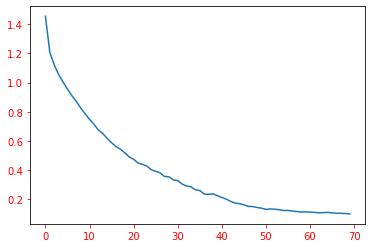

In [27]:
print_result(encoder3, decoder3, True)
show(loss_list, result1, result2)

# Teacher forcing:1, hidden_size=512, layer=5, lr=0.01,epochs:80

In [30]:
hidden_size = 512
teacher_forcing_ratio = 1
encoder4 = EncoderLSTM(vocab_size, hidden_size).to(device)
decoder4 = DecoderLSTM(hidden_size, vocab_size).to(device)
loss_list, result1, result2 = trainIters(encoder4, decoder4, 12925, print_every=100,epochs=80)

epoch : 0
7m 52s (- 0m 0s) (12900 99%) 2.11066
test:
	score : 0.04072174533000042
	acc : 0.0

new_test:
	score : 0.05630863988187811
	acc : 0.0
--------------------------------------------------
epoch : 1
6m 37s (- 0m 0s) (12900 99%) 1.90196
test:
	score : 0.05226621777971094
	acc : 0.0

new_test:
	score : 0.05250355730960401
	acc : 0.0
--------------------------------------------------
epoch : 2
8m 10s (- 0m 0s) (12900 99%) 1.30826
test:
	score : 0.09487182628018591
	acc : 0.0

new_test:
	score : 0.07915453967319236
	acc : 0.0
--------------------------------------------------
epoch : 3
7m 54s (- 0m 0s) (12900 99%) 0.90071
test:
	score : 0.10299683996103064
	acc : 0.0

new_test:
	score : 0.08860292233132937
	acc : 0.0
--------------------------------------------------
epoch : 4
8m 0s (- 0m 0s) (12900 99%) 0.656775
test:
	score : 0.19189190611093718
	acc : 0.0

new_test:
	score : 0.14173018285360606
	acc : 0.02
--------------------------------------------------
epoch : 5
5m 44s (- 0m 0


test:
	score : 0.9098527199851248
	acc : 0.86
input:  contenpted
target: contented
pred:   contented
input:  begining
target: beginning
pred:   beginning
input:  problam
target: problem
pred:   problem
input:  dirven
target: driven
pred:   driven
input:  ecstacy
target: ecstasy
pred:   ecstasy
input:  juce
target: juice
pred:   juice
input:  localy
target: locally
pred:   locally
input:  compair
target: compare
pred:   compare
input:  pronounciation
target: pronunciation
pred:   pronunciation
input:  transportibility
target: transportability
pred:   transportability
input:  miniscule
target: minuscule
pred:   minuscule
input:  independant
target: independent
pred:   independent
input:  aranged
target: arranged
pred:   erranged
input:  poartry
target: poetry
pred:   porter
input:  leval
target: level
pred:   level
input:  basicaly
target: basically
pred:   basically
input:  triangulaur
target: triangular
pred:   triangular
input:  unexpcted
target: unexpected
pred:   unexpected
input: 

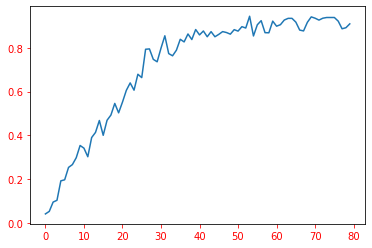

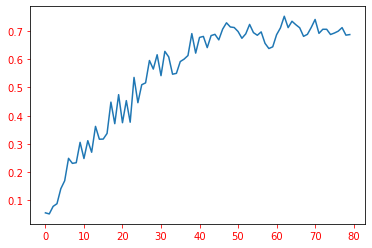

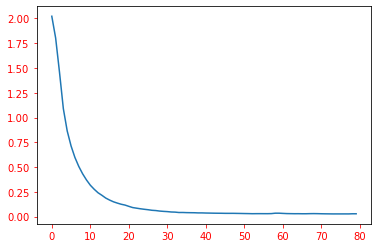

In [31]:
print_result(encoder4, decoder4,True)
show(loss_list, result1, result2)